In [288]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy

torch.manual_seed(42)


## Simple A/B test

P-Value: 0.1440


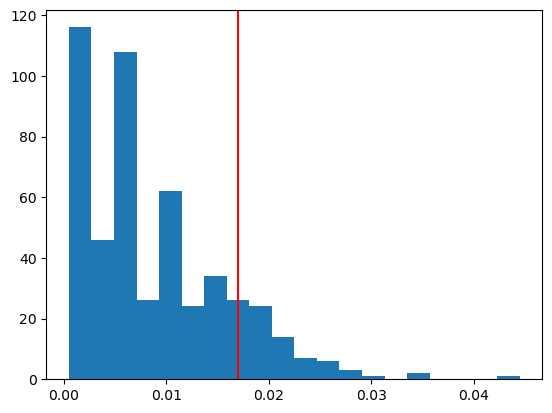

In [289]:
n_sim = 500

my_viewsA = 98
my_viewsB = 162
all_views = my_viewsA + my_viewsB

n_impsA = 1000
n_impsB = 2000
all_imps = n_impsA + n_impsB

obs_T = abs(my_viewsA/n_impsA - my_viewsB/n_impsB)

resampled_Ts = np.zeros(n_sim)

for cur_sim in range(n_sim):
    # Pool with 1s for views and 0s for non-views
    pool = np.array([1]*all_views + [0]*(all_imps - all_views))
    
    # Sample without replacement for impsA
    impsA = np.random.choice(pool, n_impsA, replace=False)
    viewsA = np.sum(impsA)
    viewsB = all_views - viewsA
    
    resampled_Ts[cur_sim] = abs(viewsA/n_impsA - viewsB/n_impsB)

p_value = sum([1 for t in resampled_Ts if t >= obs_T]) / n_sim

print(f"P-Value: {p_value:.4f}")


plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T, color='red')
plt.show()



## Independence test with neural networks

In [290]:
class NNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(NNet, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(in_dim, 2*in_dim),
            nn.ReLU(),
            nn.Linear(2*in_dim, out_dim))

    def forward(self, x):
        return self.sequential(x)

In [291]:

p1 = 5
p2 = 3

signal_strength = 0.2

n_samples = 400

X = np.random.randn(n_samples, p1)

B = np.random.randn(p2, p1)
B = B / np.linalg.norm(B, ord='fro')

Y = signal_strength * X @ B.T + np.random.randn(n_samples, p2)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

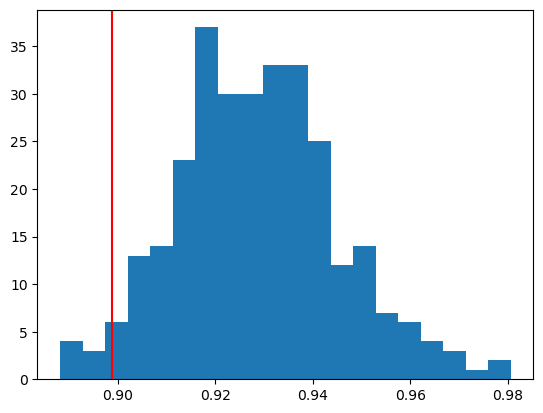

Observed test statistic: 0.8989
P-Value: 0.0333


In [294]:
def trainerr(x, y, epochs=100):
    net = NNet(p1, p2)

    optimizer = optim.Adam(net.parameters(), lr=0.2)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(x)
        
        loss = nn.MSELoss(reduction='mean')(outputs, y)
        loss.backward()
        optimizer.step()
    return loss.item()


obs_T = trainerr(X, Y)

# Perform permutation testing
n_permutations = 300
resampled_Ts = []

for _ in range(n_permutations):
    permuted_Y = Y[torch.randperm(n_samples)]
    resampled_T = trainerr(X, permuted_Y)
    resampled_Ts.append(resampled_T)

# Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

# plot distribution of permuted_test_statistics
plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T, color='red')
plt.show()


print(f"Observed test statistic: {obs_T:.4f}")
print(f"P-Value: {p_value:.4f}")



Mean Test Errors: 3.1290
Mean Null Test Errors: 3.1798


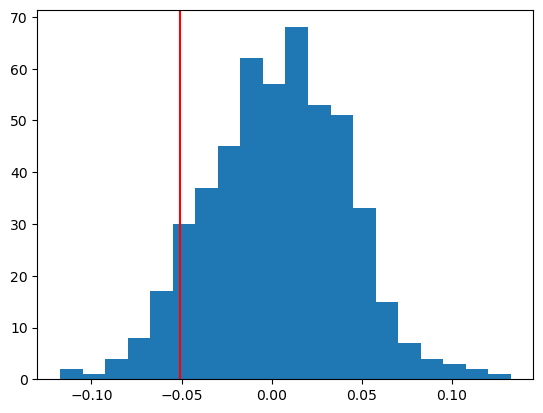

P-Value: 0.0800


In [293]:
## sample split
ntrain = int(n_samples * 0.7)
ntest = n_samples - ntrain

X_train = X[:ntrain]
X_test = X[ntrain:]

Y_train = Y[:ntrain]
Y_test = Y[ntrain:]

net = NNet(p1, p2)

Y_train_centered = Y_train - torch.mean(Y_train, dim=0)

epochs = 200
optimizer = optim.SGD(net.parameters(), lr=.1)
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(X_train)
        
    loss = nn.MSELoss(reduction='mean')(outputs, Y_train_centered)
    loss.backward()
    optimizer.step()

testerrs = torch.sum((Y_test - net(X_test) - torch.mean(Y_train, dim=0))**2, dim=1)
mean_testerr = torch.mean(testerrs)

nullerrs = torch.sum((Y_test - torch.mean(Y_train, dim=0))**2, dim=1)
mean_nullerr = torch.mean( nullerrs )

print(f"Mean Test Errors: {mean_testerr:.4f}")
print(f"Mean Null Test Errors: {mean_nullerr:.4f}")

obs_T = mean_testerr - mean_nullerr

combined = torch.stack((testerrs, nullerrs), dim=1)

n_permutations = 500
resampled_Ts = []

for _ in range(n_permutations):
    heads = torch.randint(0, 2, (ntest,))

    resampled_testerrs = combined[torch.arange(ntest), heads]
    resampled_nullerrs = combined[torch.arange(ntest), 1-heads]
    
    resampled_T = torch.mean(resampled_testerrs) - torch.mean(resampled_nullerrs)
    resampled_Ts.append(resampled_T)

## Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

resampled_Ts = [t.detach().numpy() for t in resampled_Ts]
plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T.detach().numpy(), color='red')
plt.show()

print(f"P-Value: {p_value:.4f}")
